# 1. Basic Image Registration with Twocan

This notebook demonstrates a basic image registration workflow using the `Twocan` library. We will register an example same-slide IF and IMC image using the default utilities:
1. Preprocessors `IFprocessor` and `IMCprocessor`
1. `RegEstimator` to get the transformation matrix
1. `registation_trial` and `iou_corr_single_objective` which are designed for IF/IMC registration

Custom functions can be provided in place of these defaults to register pairs of images of different technologies or experimental set ups (eg. serial sections) 

We will set the IF as the "fixed" or target image, and IMC as the "moving" or soruce image. 

# 1. A note on data formats
# 1. Using callbacks (& other Optuna features)
# 1. Custom trial & objectives
# 1. Picking registration channels
# 1. Rescaling for mismatched resolution


In [ ]:
import numpy as np
import pandas as pd
from twocan import IFProcessor, IMCProcessor, RegEstimator, registration_trial, iou_corr_single_objective
from twocan.utils import pick_best_registration 
from twocan.plotting import plot_registration
import matplotlib.pyplot as plt
from spatialdata import SpatialData, read_zarr
import optuna

/home/harrigan/.conda/envs/twocan/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/home/harrigan/.conda/envs/twocan/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
import os
os.chdir('/home/harrigan/repair-quant/twocan_repo/notebooks')

## Load data

In [3]:
sdata = read_zarr('examples/01_imc_if/data/cell-line-0028-bd18455.zarr')

Both the IF and IMC image are saved into this zarr, with their channel names. The IMC image has a transformation matrix in the 'aligned' coordinate system, and we will show how this matrix was found using Twocan.  

In [4]:
sdata['IF']

<xarray.DataArray 'image' (c: 3, y: 512, x: 512)> Size: 2MB
dask.array<from-zarr, shape=(3, 512, 512), dtype=uint16, chunksize=(3, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U4 48B 'DAPI' 'GFP' 'RFP'
  * y        (y) float64 4kB 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
  * x        (x) float64 4kB 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
Attributes:
    transform:  {'global': Identity }

In [5]:
sdata['IMC']

<xarray.DataArray 'image' (c: 24, y: 944, x: 953)> Size: 86MB
dask.array<from-zarr, shape=(24, 944, 953), dtype=float32, chunksize=(24, 944, 953), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U12 1kB '-' 'pHH3_S28' '-' '-' ... 'PCNA' 'DNA1' 'DNA2' '-'
  * y        (y) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 940.5 941.5 942.5 943.5
  * x        (x) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 949.5 950.5 951.5 952.5
Attributes:
    transform:  {'global': Identity , 'aligned': Sequence \n    Identity \n  ...

In [6]:
sdata.images

{'IF': <xarray.DataArray 'image' (c: 3, y: 512, x: 512)> Size: 2MB
dask.array<from-zarr, shape=(3, 512, 512), dtype=uint16, chunksize=(3, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U4 48B 'DAPI' 'GFP' 'RFP'
  * y        (y) float64 4kB 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
  * x        (x) float64 4kB 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
Attributes:
    transform:  {'global': Identity }, 'IMC': <xarray.DataArray 'image' (c: 24, y: 944, x: 953)> Size: 86MB
dask.array<from-zarr, shape=(24, 944, 953), dtype=float32, chunksize=(24, 944, 953), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) <U12 1kB '-' 'pHH3_S28' '-' '-' ... 'PCNA' 'DNA1' 'DNA2' '-'
  * y        (y) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 940.5 941.5 942.5 943.5
  * x        (x) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 949.5 950.5 951.5 952.5
Attributes:
    transform:  {'global': Identity , 'aligned': Sequence \n    Identity \n  ...}

In [7]:
## Run optimization to find the best registration parameters

We will register using nuclear channels: DAPI and DNA1/DNA2 respectively. All channels with matching names to the list will be summed along the channel axis to create the registration image. That is: DAPI will be registered to the DNA1+DNA2 signal.

In [8]:
registration_channels = ['DAPI', 'DNA1', 'DNA2']
correlation_channels = ['GFP', 'RFP']

The resolution of the IF image (1.714um/px) is different from the IMC (1um/px)

In [9]:
study = optuna.create_study(direction='maximize', study_name="example_1", sampler=optuna.samplers.TPESampler(seed=435))

[I 2025-05-29 23:10:04,287] A new study created in memory with name: example_1


In [17]:
study.optimize(lambda trial: iou_corr_single_objective(trial, sdata, registration_channels, correlation_channels), n_trials=100)

[I 2025-05-29 23:13:54,857] Trial 74 finished with value: 0.606051768526489 and parameters: {'IF_binarization_threshold': 0.023051918423522826, 'IF_gaussian_sigma': 0.41492083084960785, 'IMC_arcsinh_normalize': False, 'IMC_arcsinh_cofactor': 74.46447442086576, 'IMC_winsorization_lower_limit': 0.18333427749576028, 'IMC_winsorization_upper_limit': 0.0615777624518764, 'IMC_binarization_threshold': 0.4132098146518948, 'IMC_gaussian_sigma': 2.359809325254669, 'binarize_images': True, 'registration_max_features': 100000, 'registration_percentile': 0.9, 'moving_image': 'IMC', 'static_image': 'IF'}. Best is trial 69 with value: 0.7170164860003657.


## Pick best trial

We can checkout the parameters selected for the best trial
Twocan suggests the best trial based on the balanced score, this is not necessarily the same trial as that which maximizes the optimization objectives: this can be extracted with the optuna method `study.best_trial`

In [18]:
optuna_best_trial = study.best_trial
print(optuna_best_trial)

FrozenTrial(number=69, state=TrialState.COMPLETE, values=[0.7170164860003657], datetime_start=datetime.datetime(2025, 5, 29, 23, 12, 54, 828782), datetime_complete=datetime.datetime(2025, 5, 29, 23, 12, 57, 353228), params={'IF_binarization_threshold': 0.03434665503816838, 'IF_gaussian_sigma': 0.1625850872389713, 'IMC_arcsinh_normalize': False, 'IMC_arcsinh_cofactor': 90.71740690650462, 'IMC_winsorization_lower_limit': 0.19916139257481844, 'IMC_winsorization_upper_limit': 0.07038754802100661, 'IMC_binarization_threshold': 0.4135779100577611, 'IMC_gaussian_sigma': 1.9252828823481996, 'binarize_images': True, 'registration_max_features': 100000, 'registration_percentile': 0.9, 'moving_image': 'IMC', 'static_image': 'IF'}, user_attrs={'registration_matrix': array([[ 5.81153556e-01,  2.49409559e-03, -2.82827661e+01],
       [-2.49409559e-03,  5.81153556e-01, -2.25687258e+01]]), 'source_sum': 29134, 'target_sum': 27733, 'logical_and': 25600, 'logical_or': 31267, 'logical_xor': 5667, 'logica

In [19]:
twocan_best_trial = pick_best_registration(study.trials_dataframe())
print(twocan_best_trial)

number                                                                                 69
value                                                                            0.717016
datetime_start                                                 2025-05-29 23:12:54.828782
datetime_complete                                              2025-05-29 23:12:57.353228
duration                                                           0 days 00:00:02.524446
params_IF_binarization_threshold                                                 0.034347
params_IF_gaussian_sigma                                                         0.162585
params_IMC_arcsinh_cofactor                                                     90.717407
params_IMC_arcsinh_normalize                                                        False
params_IMC_binarization_threshold                                                0.413578
params_IMC_gaussian_sigma                                                        1.925283
params_IMC

We can also check out the registration matrix

In [20]:
twocan_best_trial['user_attrs_registration_matrix'].round(2)

array([[  0.58,   0.  , -28.28],
       [ -0.  ,   0.58, -22.57]])

## Visualize result

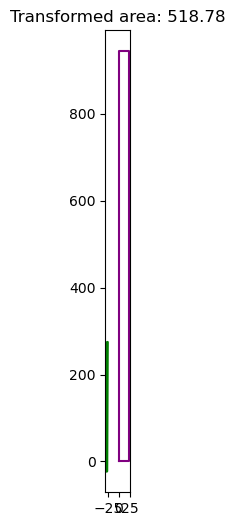

In [27]:
plt.figure(figsize=(20, 6))
plot_registration(sdata['IF'], sdata['IMC'], twocan_best_trial['user_attrs_registration_matrix'])
plt.show()